## Description

**The field of biomedical imaging has exploded in recent years - but for the uninitiated, even loading data can be a challenge! I'll navigate through a whole-body CT scan, segment a cardiac MRI time series, and determine whether Alzheimer’s disease changes brain structure. You'll navigate through a whole-body CT scan, segment a cardiac MRI time series, and determine whether Alzheimer’s disease changes brain structure.** 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os
import scipy.ndimage as ndi
from scipy.stats import ttest_ind

### Exploration

In [2]:
# Load "chest-220.dcm"
im = imageio.imread('chest-220.dcm')

# Print image attributes
print('Image type:', type(im))
print('Shape of image array:', im.shape)

Image type: <class 'imageio.core.util.Array'>
Shape of image array: (512, 512)


**`imageio` is a versatile package. It can read in a variety of image data, including JPEG, PNG, and TIFF. But it's especially useful for its ability to handle DICOM files.**

#### Metadata

In [3]:
# Print the available metadata fields
print(im.meta.keys())

odict_keys(['TransferSyntaxUID', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate', 'SeriesDate', 'ContentDate', 'StudyTime', 'SeriesTime', 'ContentTime', 'Modality', 'Manufacturer', 'StudyDescription', 'SeriesDescription', 'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex', 'PatientWeight', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'AcquisitionNumber', 'InstanceNumber', 'ImagePositionPatient', 'ImageOrientationPatient', 'SamplesPerPixel', 'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation', 'RescaleIntercept', 'RescaleSlope', 'PixelData', 'shape', 'sampling'])


**DICOM files have rich information related to patient and acquisition information, but other image formats can have helpful information as well.**

#### Plot Images

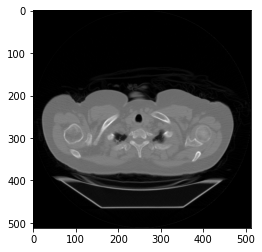

In [4]:
# Draw the image in grayscale
plt.imshow(im, cmap='gray')

# Render the image
plt.show()

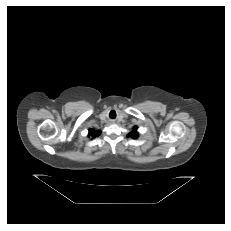

In [5]:
# Draw the image with greater contrast
plt.imshow(im, cmap = 'gray', vmin = -200, vmax = 200)

plt.axis('off')

# Render the image
plt.show()

**Manipulating `cmap`, `vmin`, and `vmax` will give us the flexibility to plot all types of data. Remember, though, that they only affect the plot and not the underlying data.**

### Stack images

In [6]:
# Read in each 2D image
im1 = imageio.imread('chest-220.dcm')
im2 = imageio.imread('chest-221.dcm')
im3 = imageio.imread('chest-222.dcm')

# Stack images into a volume
vol = np.stack([im1, im2, im3])
print('Volume dimensions:',vol.shape)

Volume dimensions: (3, 512, 512)


### Load volumes

In [7]:
os.listdir('tcia-chest-ct-sample')

['chest-220.dcm',
 'chest-221.dcm',
 'chest-222.dcm',
 'chest-224.dcm',
 'chest-225.dcm']

In [8]:
#Load the "tcia-chest-ct" directory
vol = imageio.volread("tcia-chest-ct-sample")

# Print image attributes
print('Available metadata:', vol.meta.keys())
print('Shape of image array:', vol.shape)

Reading DICOM (examining files): 1/5 files (20.0%4/5 files (80.0%5/5 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 5/5  (100.0%5/5  (100.0%)
Available metadata: odict_keys(['TransferSyntaxUID', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate', 'SeriesDate', 'ContentDate', 'StudyTime', 'SeriesTime', 'ContentTime', 'Modality', 'Manufacturer', 'StudyDescription', 'SeriesDescription', 'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex', 'PatientWeight', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'AcquisitionNumber', 'InstanceNumber', 'ImagePositionPatient', 'ImageOrientationPatient', 'SamplesPerPixel', 'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation', 'RescaleIntercept', 'RescaleSlope', 'PixelData', 'shape', 'sampling'])
Shape of image array: (5, 512, 512)


**Using `volread()` to load image volumes can be faster and more reliable than loading them in image-by-image. It also preserves image metadata where possible.**

### Field of view

The amount of physical space covered by an image is its field of view, which is calculated from two properties:

- Array shape, the number of data elements on each axis. Can be accessed with the shape attribute.
- Sampling resolution, the amount of physical space covered by each pixel. Sometimes available in metadata (e.g., meta['sampling']).

In [9]:
n0, n1, n2 = vol.shape
d0, d1, d2 = vol.meta['sampling']
field = n0 * d0, n1 * d1, n2 * d2
print(field)

(16.34999999999998, 499.999744, 499.999744)


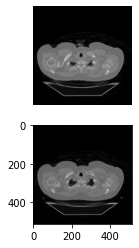

In [10]:
im1 = imageio.imread('chest-220.dcm')
im2 = imageio.imread('chest-221.dcm')

# Initialize figure and axes grid
fig, axes = plt.subplots(nrows = 2,ncols = 1)

# Draw an image on each subplot
axes[0].imshow(im1, cmap = 'gray')
axes[1].imshow(im2, cmap = 'gray')

# Remove ticks/labels and render
axes[0].axis('off')
axes[0].axis('off')
plt.show()

### Slice 3D images

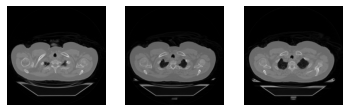

In [11]:
# Plot the images on a subplots array 
fig, axes = plt.subplots(1,3)

# Loop through subplots and draw image
for ii in range(3):
    im = vol[ii*2, :, :]
    axes[ii].imshow(im, cmap='gray')
    axes[ii].axis('off')
    
# Render the figure
plt.show()

**When selecting frames, any trailing : symbols are implicitly selected. For example, `vol[5]` is the same as `vol[5,:,:]`. We will follow this simpler convention moving forward.**

### Plot other views

Any two dimensions of an array can form an image, and slicing along different axes can provide a useful perspective. However, unequal sampling rates can create distorted images.

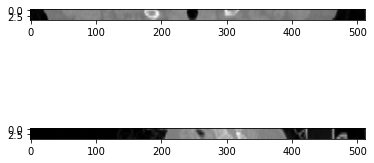

In [12]:
# Select frame from "vol"
im1 = vol[:, 256, :]
im2 = vol[:,:, 256]

# Compute aspect ratios
d0, d1, d2 = vol.meta['sampling']
asp1 = d0 / d2
asp2 = d0 / d2

# Plot the images on a subplots array 
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].imshow(im1, cmap='gray', aspect = asp1)
axes[1].imshow(im2, cmap='gray', aspect = asp2)
plt.show()

## Masks and Filters

In [13]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include:
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    fig.axes[0].axis('off')
    plt.tight_layout()
    plt.show()


Data type: uint8
Min. value: 3
Max value: 224


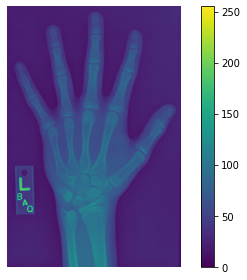

In [14]:
# Load the hand radiograph
im = imageio.imread('hand.png')
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale image
plt.imshow(im, vmin = 0, vmax = 255)
plt.colorbar()
format_and_render_plot()

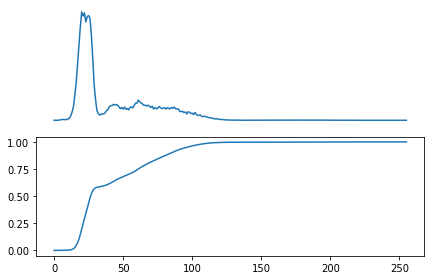

In [15]:
# Create a histogram, binned at each possible value
hist = ndi.histogram(im, min = 0, max = 255, bins = 256)

# Create a cumulative distribution function
cdf = hist.cumsum() / hist.sum()

# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hist, label='Histogram')
axes[1].plot(cdf, label='CDF')
format_and_render_plot()

**You can see the data is clumped into a few separate distributions, consisting of background noise, skin, bone, and artifacts. Sometimes we can separate these well with global thresholds (foreground/background); other times the distributions overlap quite a bit (skin/bone).**

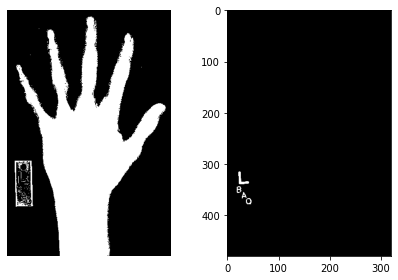

In [16]:
# Create skin and bone masks
mask_bone = (im >= 145)
mask_skin = (im >= 45) & (im < 145)

# Plot the skin (0) and bone (1) masks
fig, axes = plt.subplots(1,2)
axes[0].imshow(mask_skin, cmap = 'gray')
axes[1].imshow(mask_bone, cmap = 'gray')
format_and_render_plot()

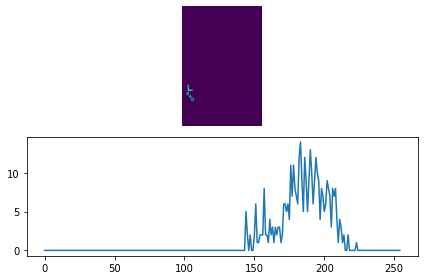

In [17]:
# Screen out non-bone pixels from "im"
mask_bone = im >= 145
im_bone = np.where(mask_bone, im, 0)

# Get the histogram of bone intensities
hist = ndi.histogram(im_bone, min = 1, max = 255, bins = 255)

# Plot masked image and histogram
fig, axes = plt.subplots(2,1)
axes[0].imshow(im_bone)
axes[1].plot(hist)
format_and_render_plot()

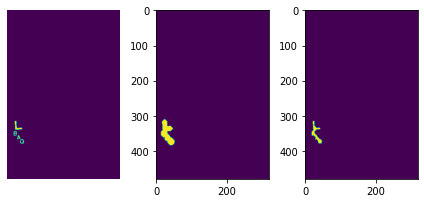

In [18]:
# Create and tune bone mask
im = imageio.imread('hand.png')
mask_bone = im >= 145
mask_dilate = ndi.binary_dilation(mask_bone, iterations = 5)
mask_closed = ndi.binary_closing(mask_bone, iterations = 5)

# Plot masked images
fig, axes = plt.subplots(1,3)
axes[0].imshow(mask_bone)
axes[1].imshow(mask_dilate)
axes[2].imshow(mask_closed)
format_and_render_plot()

### Filter convolutions

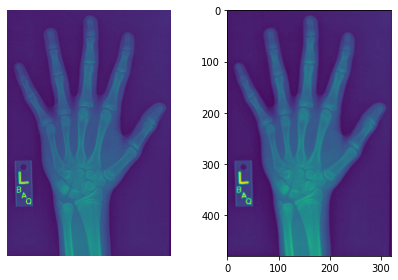

In [19]:
# Set filter weights
weights = [[0.11, 0.11, 0.11],
           [0.11, 0.11, 0.11], 
           [0.11, 0.11, 0.11]]

# Convolve the image with the filter
im_filt = ndi.convolve(im, weights)

# Plot the images
fig, axes = plt.subplots(1,2)
axes[0].imshow(im)
axes[1].imshow(im_filt)
format_and_render_plot()

### Smoothing

Smoothing can improve the signal-to-noise ratio of your image by blurring out small variations in intensity. The Gaussian filter is excellent for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones.

The width of the distribution is controlled by the sigma argument, with higher values leading to larger smoothing effects.

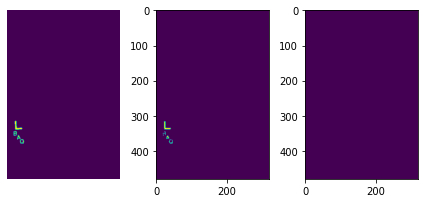

In [20]:
# Smooth "im" with Gaussian filters
im_s1 = ndi.gaussian_filter(im, sigma=1)
im_s3 = ndi.gaussian_filter(im, sigma=3)

# Draw bone masks of each image
fig, axes = plt.subplots(1,3)
axes[0].imshow(im >= 145)
axes[1].imshow(im_s1 >= 145)
axes[2].imshow(im_s3 >= 145)
format_and_render_plot()

### Detect edges (1)

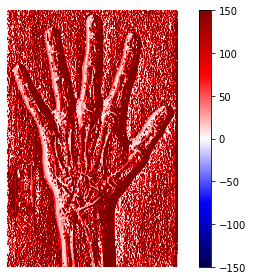

In [21]:
# Set weights to detect vertical edges
weights = [[1, 0, -1], [1, 0, -1], [1, 0, -1]]

# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
plt.imshow(edges, cmap = 'seismic', vmin=-150, vmax=150)
plt.colorbar()
format_and_render_plot()

## Detect edges (2)

Edge detection can be performed along multiple axes, then combined into a single edge value. For 2D images, the horizontal and vertical "edge maps" can be combined using the Pythagorean theorem:


One popular edge detector is the `Sobel` filter. The `Sobel` filter provides extra weight to the center pixels of the detector:

<ipython-input-22-faad980a9287>:7: RuntimeWarning: invalid value encountered in sqrt
  edges = np.sqrt(np.square(sobel_ax0) + np.square(sobel_ax1))


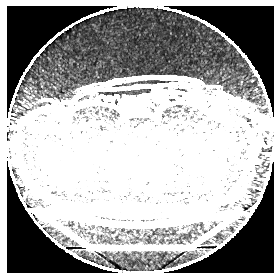

In [22]:
# Apply Sobel filter along both axes
im = imageio.imread('chest-220.dcm')
sobel_ax0 = ndi.sobel(im, axis=0)
sobel_ax1 = ndi.sobel(im, axis = 1)

# Calculate edge magnitude 
edges = np.sqrt(np.square(sobel_ax0) + np.square(sobel_ax1))

# Plot edge magnitude
plt.imshow(edges, cmap = 'gray', vmax = 75)
format_and_render_plot()

## Measurement

**Here we'll get to the heart of image analysis: object measurement. Using a 4D cardiac time series, we'll determine if a patient is likely to have heart disease. Along the way, you'll learn the fundamentals of image segmentation, object labeling, and morphological measurement.**



(-0.5, 255.5, 255.5, -0.5)

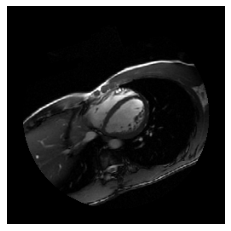

In [23]:
im = imageio.imread('SCD2001_MR_117.dcm')
plt.imshow(im, cmap = 'gray')
plt.axis('off')

In [24]:
# Smooth intensity values
im_filt = ndi.median_filter(im, size = 3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 26


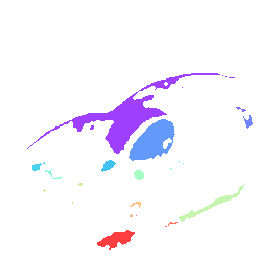

In [25]:
# Create a `labels` overlay
overlay = np.where(labels > 0,labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot()

**Robust image segmentation is an entire research domain, but the simple principle is to leverage intensity and location information to differentiate objects of interest from the background. Once labeled, the objects can be manipulated easily.**

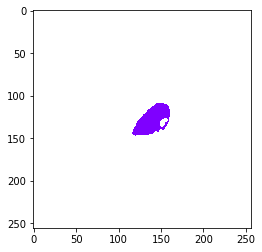

In [26]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

**When running `ndi.label()`, the image is traversed from top-left to bottom right, so the generated label value could change depending on how many objects are detected. You may need to plot your labeled image to get the appropriate region.**

### Extract objects

Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.

The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the bounding box.

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


(-0.5, 45.5, 41.5, -0.5)

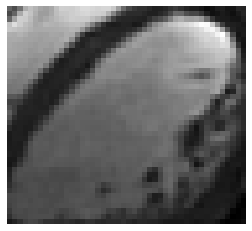

In [27]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap = 'gray')
plt.axis('off')

**`ndi.find_objects()` becomes extremely useful when dealing with 3-dimensional objects that are harder to view at a glance.**

**The ejection fraction is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.**

In [28]:
os.listdir('SCD2001_006')
vol_ts = imageio.volread('SCD2001_006')

Reading DICOM (examining files): 1/21 files (4.8%3/21 files (14.34/21 files (19.06/21 files (28.68/21 files (38.110/21 files (47.6%12/21 files (57.1%14/21 files (66.7%17/21 files (81.0%19/21 files (90.5%20/21 files (95.2%21/21 files (100.021/21 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 3/21  (14.3%7/21  (33.3%10/21  (47.612/21  (57.115/21  (71.420/21  (95.221/21  (100.0%)


In [29]:
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel


## Image Comparison

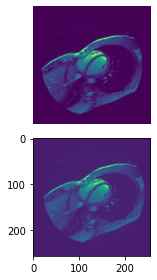

In [30]:
# Find image center of mass
com = ndi.center_of_mass(im)

# Calculate amount of shift needed
d0 = 128 - com[0]
d1 = 128 - com[1]

# Translate the brain towards the center
xfm = ndi.shift(im, shift=(d0, d1))

# Plot the original and adjusted images
fig, axes = plt.subplots(2,1)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

(-0.5, 255.5, 255.5, -0.5)

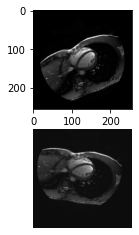

In [31]:
# Shift the image towards the center
xfm = ndi.shift(im, shift=(-20, -20))

# Rotate the shifted image
xfm = ndi.rotate(xfm, angle=-30, reshape=False)

# Plot the original and transformed images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im, cmap = 'gray')
axes[1].imshow(xfm, cmap = 'gray')
plt.axis('off')

**The order of transformations makes a difference: rotating the image first will alter the object center, changing the amount of shift needed.**

### Affine transform
An affine transformation matrix provides directions for up to four types of changes: translating, rotating, rescaling and shearing. The elements of the matrix map the coordinates from the input array to the output.

### Resampling

Images can be collected in a variety of shapes and sizes. Resampling is a useful tool when these shapes need to be made consistent. Two common applications are:

- Downsampling: combining pixel data to decrease size
- Upsampling: distributing pixel data to increase size

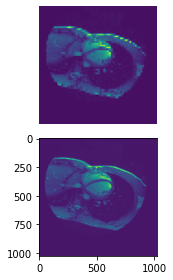

In [32]:
# Center and level image
xfm = ndi.shift(im, shift=(-20, -20))
xfm = ndi.rotate(xfm, angle=-35, reshape=False)

# Resample image
im_dn = ndi.zoom(xfm, zoom=0.25)
im_up = ndi.zoom(xfm, zoom=4.00)

# Plot the images
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im_dn)
axes[1].imshow(im_up)
format_and_render_plot()

In [33]:
def format_and_render_plots():
    '''Custom function to simplify common formatting operations for exercises. Operations include:
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
        plt.tight_layout()
        plt.show()


### Interpolation

Interpolation is how new pixel intensities are estimated when an image transformation is applied. It is implemented in SciPy using sets of spline functions.

Editing the interpolation order when using a function such as `ndi.zoom()` modifies the resulting estimate: higher orders provide more flexible estimates but take longer to compute.

Original shape: (256, 256)
Upsampled shape: (1024, 1024)


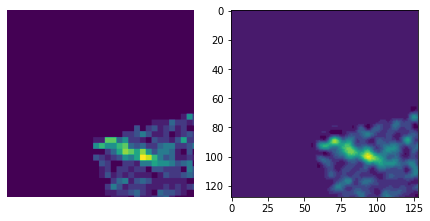

<Figure size 432x288 with 0 Axes>

In [34]:
# Upsample "im" by a factor of 4
up0 = ndi.zoom(im, zoom=4, order=0)
up5 = ndi.zoom(im, zoom=4, order=5)

# Print original and new shape
print('Original shape:', im.shape)
print('Upsampled shape:', up0.shape)

# Plot close-ups of the new images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(up0[128:256, 128:256])
axes[1].imshow(up5[128:256, 128:256])
format_and_render_plots()

### Comparison of images using Mean Absolute Error

Cost functions and objective functions output a single value that summarizes how well two images match.

The mean absolute error (MAE), for example, summarizes intensity differences between two images, with higher values indicating greater divergence.

In [35]:
im1 = imageio.imread('chest-220.dcm')
im2 = imageio.imread('chest-221.dcm')

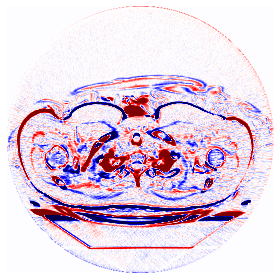

In [36]:
# Calculate image difference
err = im1 - im2

# Plot the difference
plt.imshow(err, cmap = 'seismic', vmin = -200, vmax = 200)
format_and_render_plot()

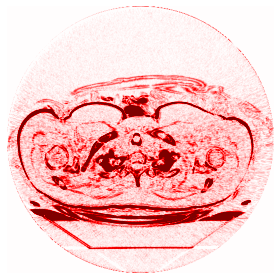

In [37]:
# Calculate absolute image difference
abs_err = np.abs(im1 - im2)

# Plot the difference
plt.imshow(abs_err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

In [38]:
# Calculate mean absolute error
mean_abs_err = np.mean(np.abs(im1 - im2))
print('MAE:', mean_abs_err)

MAE: 37.21159744262695


**The MAE metric allows for variations in weighting throughout the image, which gives areas with high pixel intensities more influence on the cost calculation than others.**

### Intersection of the union
Another cost function is the intersection of the union (IOU). The IOU is the number of pixels filled in both images (the intersection) out of the number of pixels filled in either image (the union).

In [39]:
def intersection_of_union(im1, im2):
    i = np.logical_and(im1, im2)
    u = np.logical_or(im1, im2)
    return i.sum() / u.sum()

### Identifying potential confounds
Once measures have been extracted, double-check for dependencies within your data. This is especially true if any image parameters (sampling rate, field of view) might differ between subjects, or you pull multiple measures from a single image.

In [42]:
oasis = pd.read_csv('oasis_all_volumes.csv')

In [43]:
df = oasis[['age', 'sex', 'alzheimers', 'brain_vol', 'skull_vol']]

In [44]:
# Print random sample of rows
print(df.sample(3))

# Print prevalence of Alzheimer's Disease
print(df.alzheimers.value_counts())

# Print a correlation table
print(df.corr())

     age sex  alzheimers  brain_vol    skull_vol
311   43   F       False    933.523  1400.255991
12    19   F       False   1085.746  1415.618348
341   38   F       False   1114.312  1426.762334
False    332
True      93
Name: alzheimers, dtype: int64
                 age  alzheimers  brain_vol  skull_vol
age         1.000000    0.542463  -0.719211  -0.141576
alzheimers  0.542463    1.000000  -0.446771   0.014222
brain_vol  -0.719211   -0.446771   1.000000   0.654829
skull_vol  -0.141576    0.014222   0.654829   1.000000


**There is a high correlation - nearly 0.7 - between the brain_vol and skull_vol. We should be wary of this (and other highly correlated variables) when interpreting results.**

### Testing group differences
Let's test the hypothesis that Alzheimer's Disease is characterized by reduced brain volume.

We can perform a two-sample t-test between the brain volumes of elderly adults with and without Alzheimer's Disease. In this case, the two population samples are independent from each other because they are all separate subjects.

t =  -10.27076306169677
p =  3.043550344658516e-22


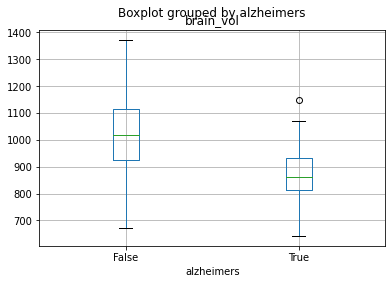

In [49]:
# Import independent two-sample t-test
from scipy.stats import ttest_ind

# Select data from "alzheimers" and "typical" groups
brain_alz = df.loc[df.alzheimers == True, 'brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'brain_vol']

# Perform t-test of "alz" > "typ"
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

# Show boxplot of brain_vol differences
df.boxplot(column='brain_vol', by='alzheimers')
plt.show()

**There is some evidence for decreased brain volume in individuals with Alzheimer's Disease. Since the p-value for this t-test is greater than 0.05, we would not reject the null hypothesis that states the two groups are equal.**

### Normalizing metrics
We previously saw that there was not a significant difference between the brain volumes of elderly individuals with and without Alzheimer's Disease.

In [51]:
# Adjust `brain_vol` by `skull_vol`
df['adj_brain_vol'] = df.brain_vol / df.skull_vol

# Select brain measures by group
brain_alz = df.loc[df.alzheimers == True, 'adj_brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'adj_brain_vol']

# Evaluate null hypothesis
results = ttest_ind(brain_alz, brain_typ)
results.statistic
results.pvalue

<ipython-input-51-4f84aa195be2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adj_brain_vol'] = df.brain_vol / df.skull_vol


2.019286086120867e-42

**Is there strong evidence that Alzheimer's Disease is marked by smaller brain size, relative to skull size?**

**Yes, reject the null hypothesis!**